### Classification problem - Stroke Prediction Dataset

Distribution of the datatset is heavily imbalanced. Two different approaches - SMOTE and Undersampling techniques are explored to understand better out of the two methods

#### Importing the necessary libraries

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, recall_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.tree import  DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [63]:
# Importing the data
strokedf = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [64]:
# Summary of the dataset:
strokedf.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [65]:
# Number of rows and columns of the dataset
strokedf.shape

(5110, 12)

In [66]:
strokedf.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [67]:
strokedf = strokedf.drop('id',  axis=1)

In [68]:
# Checking for any null values in the datset
strokedf.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [69]:
# Finding the mean BMIs
female_bmi_mean = strokedf[strokedf['gender']=='Female']['bmi'].mean()
male_bmi_mean = strokedf[strokedf['gender']=='Male']['bmi'].mean()
female_bmi_mean,male_bmi_mean

(29.065757680358992, 28.64793635007459)

In [70]:
strokedf[strokedf['gender'] == 'Female']['bmi'].isna().sum(), strokedf[strokedf['gender'] == 'Male']['bmi'].isna().sum()

(97, 104)

In [71]:
# Replacing the null values with the average BMI value
strokedf.loc[strokedf['gender']=='Female', 'bmi'] = strokedf.loc[strokedf['gender'] =='Female', 'bmi'].fillna(female_bmi_mean)
strokedf.loc[strokedf['gender']=='Male', 'bmi'] = strokedf.loc[strokedf['gender'] =='Male', 'bmi'].fillna(male_bmi_mean)

In [72]:
strokedf.bmi.isna().sum()

0

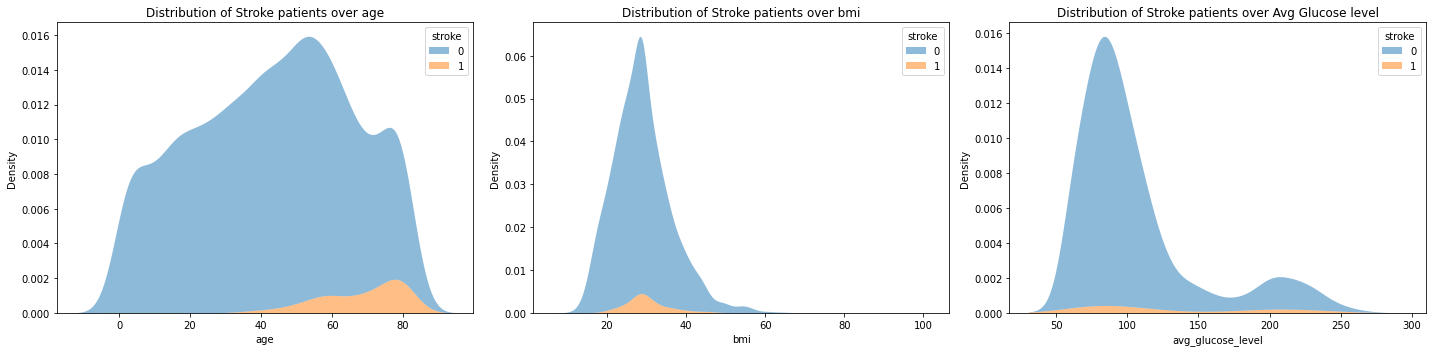

In [73]:
# Plotting various graphs 

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.kdeplot(data=strokedf, x='age',hue="stroke", fill=True, alpha=.5, linewidth=0,  multiple="stack" , ax= ax[0])
ax[0].set_title('Distribution of Stroke patients over age')

sns.kdeplot(data=strokedf, x='bmi',hue="stroke", fill=True, alpha=.5, linewidth=0,  multiple="stack", ax=ax[1] )
ax[1].set_title('Distribution of Stroke patients over bmi')

sns.kdeplot(data=strokedf, x='avg_glucose_level',hue="stroke", fill=True, alpha=.5, linewidth=0,  multiple="stack", ax=ax[2])
ax[2].set_title('Distribution of Stroke patients over Avg Glucose level')
plt.tight_layout()


In [74]:
strokedf.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [75]:
# Converting categorical values to numerical values
labelencoder = LabelEncoder()
strokedf['gender'] = labelencoder.fit_transform(strokedf['gender'])
strokedf['Residence_type'] = labelencoder.fit_transform(strokedf['Residence_type'])
strokedf['work_type'] = labelencoder.fit_transform(strokedf['work_type'])
strokedf['smoking_status'] = labelencoder.fit_transform(strokedf['smoking_status'])

<AxesSubplot:>

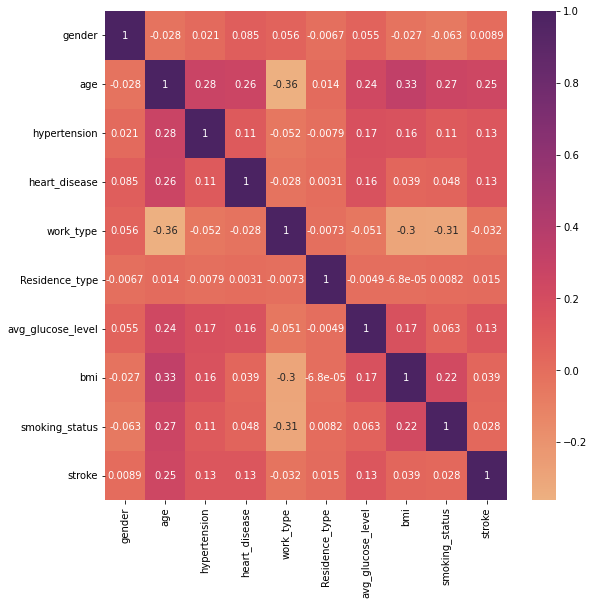

In [76]:
# Plotting the corelation matrix of all the columns
fig, ax = plt.subplots(figsize=(9,9))
sns.heatmap(strokedf.corr(), cmap = 'flare', annot=True)

0    4861
1     249
Name: stroke, dtype: int64

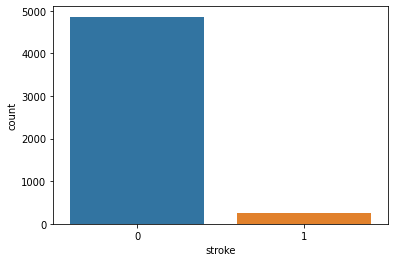

In [77]:
# Checking the class balance in the dataset
sns.countplot(x = strokedf.stroke)
strokedf['stroke'].value_counts()

In [78]:
# Splitting the dataset inti test/train datasets
X_train, X_test, y_train, y_test = train_test_split(strokedf.drop(['ever_married','stroke'], axis=1), strokedf.stroke, test_size = 0.20, shuffle=True, random_state=77)

In [79]:
# Scaling the features for faster training of the models
scaler = StandardScaler()
X_train_1 = scaler.fit_transform(X_train)
X_test_1 = scaler.transform(X_test)

Wrongly predicting a patient with actual stroke symptoms as not at risk of stroke can turn out deadly for the patients. So its necessary to keep false negatives at a minimum. In order to achieve this, hyperparameters are tuned such that recall values are maximized.

In [80]:
# Functions to find the best hyperparameters for the models: Hyper-parameter tuning
#SVM
def svm(X_train, y_train):
    params = {'C': [0.1, 1.0, 10.0, 50.0], 'kernel': ['linear','rbf', 'poly', 'sigmoid'], 'gamma' :[0.001,0.01, 0.1, 1] }
    gridsearch = GridSearchCV(SVC(), param_grid=params, pre_dispatch='None', cv=2, refit=True, scoring = 'recall', verbose=2 )
    gridsearch.fit(X_train, y_train)
    print(gridsearch.best_estimator_)

#KNN
def knn(X_train, y_train):
    params = {'n_neighbors' : [1,2,3,5,7,10], 'weights' : ['uniform', 'distance'], 'algorithm':['auto', 'kd_tree']}
    gridsearch = GridSearchCV(KNeighborsClassifier(), param_grid=params, pre_dispatch='None', cv=2, refit=True, scoring = 'recall', verbose=2 )
    gridsearch.fit(X_train, y_train)
    print(gridsearch.best_estimator_)

#XGB
def xgb(X_train, y_train):
    params = {'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5],'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0],'max_depth': [3, 4, 5]}
    gridsearch = GridSearchCV(XGBClassifier(), param_grid=params, pre_dispatch='None', cv=2, refit=True, scoring = 'recall', verbose=2 )
    gridsearch.fit(X_train, y_train)
    print(gridsearch.best_estimator_)

# Function to calculate the cross validation score
def crossvalidation(models, X_train,y_train):
	results = []
	names = []
	for name, model in models:
		kfold = StratifiedKFold(n_splits=2)
		cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall')
		results.append(cv_results)
		names.append(name)
		print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
	# Compare Algorithms
	plt.boxplot(results, labels=names)
	plt.show()


In [81]:
# Function to train  the models and to find the evaluation matrices for plotting
results_recall = []
results_acc = []
results_roc = []
def train_test(models, X_train, y_train,  X_test, y_test):
    result_recall =[]
    result_acc = []
    result_roc =[]
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    fig.suptitle('Confusion Matrix')
    
    fig2 = plt.figure()
    ax2 = fig2.add_axes([0,0,1,1])

    fig3 = plt.figure()
    ax3 = fig3.add_axes([0,0,1,1])

    fig4 = plt.figure()
    ax4 = fig4.add_axes([0,0,1,1])

    i=0
    for name, model in models:

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print('========================='+ name +'============================')
        print(classification_report(y_test, y_pred))

        recallscore = recall_score(y_test,y_pred)
        result_recall.append(recallscore)
        
        acc_score = accuracy_score(y_test,y_pred)
        result_acc.append(acc_score)

        ax2.bar(name,recallscore)
        ax2.set_title('Recall Score Comparision')

        proba = model.predict_proba(X_test)
        roc_score = roc_auc_score(y_test, proba[:,1])
        result_roc.append(roc_score)
        ax4.bar(name, roc_score)
        ax4.set_title('AUC Score Comparison')


        fpr, tpr, thr = roc_curve(y_test,  proba[:,1])
        ax3.plot(fpr,tpr, label=name)
        ax3.set_xlabel('False Positive Rate')
        ax3.set_ylabel('True Positive Rate')
        ax3.set_title('ROC Curve')

        sns.heatmap(confusion_matrix(y_test, y_pred), annot =True, fmt="d", cmap = 'flare', cbar = False, ax=ax[i])
        ax[i].set_title(name, y = 0.0)  
        ax[i].set_ylabel('Actual')
        ax[i].set_xlabel('Prediction')     
        i+=1
        
    results_acc.append(result_acc)
    results_recall.append(result_recall)
    results_roc.append(result_roc)
    rand_prob= [0 for i in range(len(y_test))]
    rand_fpr, rand_tpr, rand_thr = roc_curve(y_test, rand_prob)
    ax3.plot(rand_fpr, rand_tpr, '--')

    ax3.legend(loc=4)
    plt.show()



In [82]:
#svm(X_train_1,y_train)

In [83]:
#knn(X_train_1,y_train)

In [84]:
#xgb(X_train_1,y_train)


In [85]:

models =[]
models.append(('XGBoost', XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1.5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=np.nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1)))
models.append(('SVM', SVC(C=50.0, gamma=1, kernel='sigmoid', probability=True)))
models.append(('kNN', KNeighborsClassifier(n_neighbors=1)))

XGBoost: 0.033794 (0.004668)
SVM: 0.125700 (0.019931)
kNN: 0.101335 (0.023665)


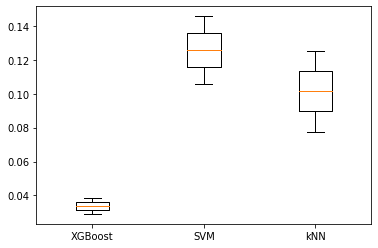

In [86]:
crossvalidation(models, X_train_1, y_train)

=========================XGBoost============================
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       980
           1       0.25      0.02      0.04        42

    accuracy                           0.96      1022
   macro avg       0.60      0.51      0.51      1022
weighted avg       0.93      0.96      0.94      1022

=========================SVM============================
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       980
           1       0.14      0.14      0.14        42

    accuracy                           0.93      1022
   macro avg       0.55      0.55      0.55      1022
weighted avg       0.93      0.93      0.93      1022

=========================kNN============================
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       980
           1       0.02      0.02      0.02        42

    acc

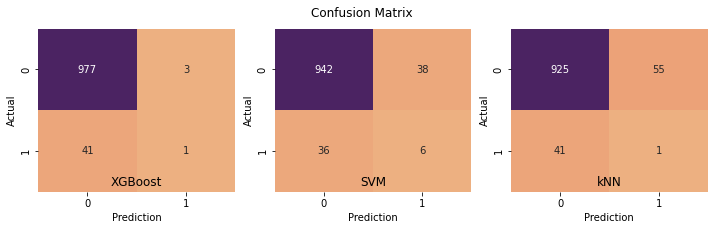

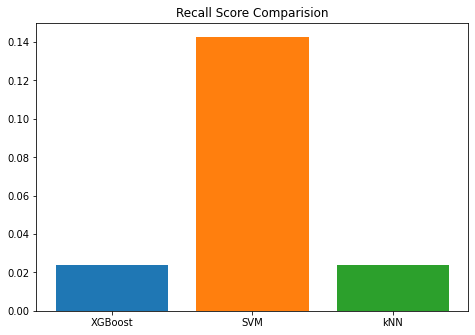

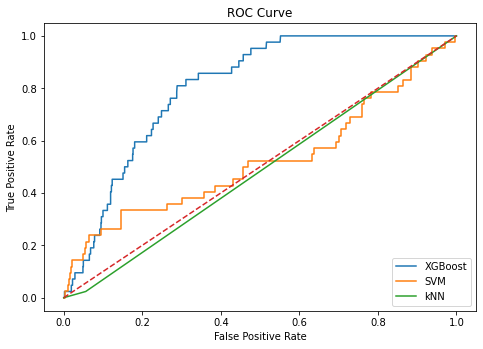

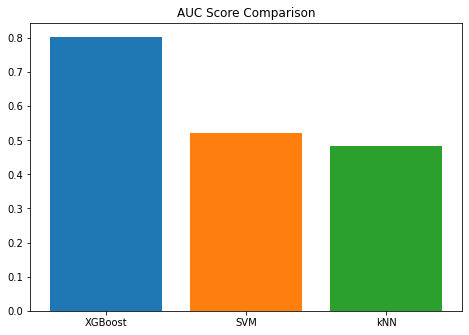

In [87]:
# Training the models 
train_test(models,  X_train_1, y_train,  X_test_1, y_test)
#0.40476190476190477,0.023809523809523808, 0.07142857142857142  

#DT - 0.958904109589041/0 
#knn - 0.917/0.07
#svm - 0.93/0.02

To avoid imbalance, SMOTE (Synthetic Minority Oversampling TEchnique) is used. SMOTE is an oversampling technique where k nearest neighbours of the minority class instance are found and instances are chosen by selecting a neighbour at random and connecting minority class instance and selected neighbour to form a line segment.

In [88]:
# Over sampling using SMOTE 
mo = SMOTE(random_state=77)
X_train_2,y_train_2 = mo.fit_resample(X_train,y_train)

In [89]:
X_train_2 = scaler.fit_transform(X_train_2)

In [90]:
y_train_2.value_counts()

0    3881
1    3881
Name: stroke, dtype: int64

In [91]:
#knn(X_train_2, y_train_2)

In [92]:
#svm(X_train_2,y_train_2)

In [93]:
#xgb(X_train_2,y_train_2)


In [94]:
models =[]
models.append(('XGBoost', XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=np.nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1)))
models.append(('SVM', SVC(C = 0.1, gamma=0.05, kernel='sigmoid', probability=True)))
models.append(('kNN', KNeighborsClassifier(n_neighbors=10, weights='distance')))

XGBoost: 0.945367 (0.029903)
SVM: 0.842823 (0.005709)
kNN: 0.963150 (0.016758)


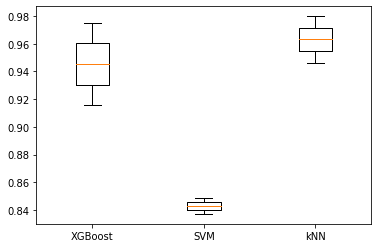

In [95]:
crossvalidation(models, X_train_2, y_train_2)

=========================XGBoost============================
              precision    recall  f1-score   support

           0       0.96      0.69      0.80       980
           1       0.04      0.33      0.08        42

    accuracy                           0.68      1022
   macro avg       0.50      0.51      0.44      1022
weighted avg       0.92      0.68      0.78      1022

=========================SVM============================
              precision    recall  f1-score   support

           0       0.99      0.53      0.69       980
           1       0.07      0.86      0.13        42

    accuracy                           0.55      1022
   macro avg       0.53      0.70      0.41      1022
weighted avg       0.95      0.55      0.67      1022

=========================kNN============================
              precision    recall  f1-score   support

           0       0.97      0.68      0.80       980
           1       0.06      0.50      0.11        42

    acc

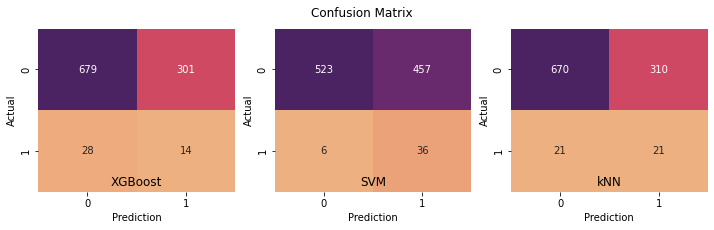

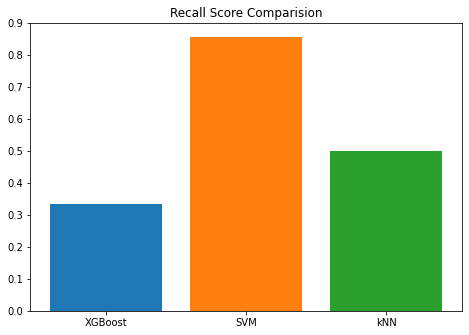

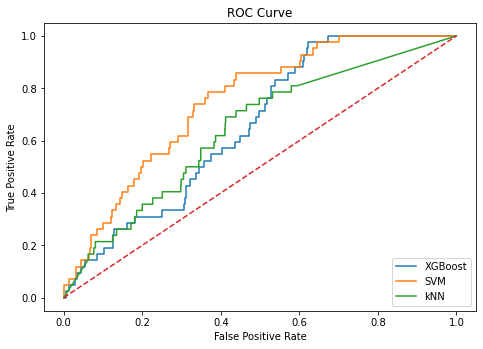

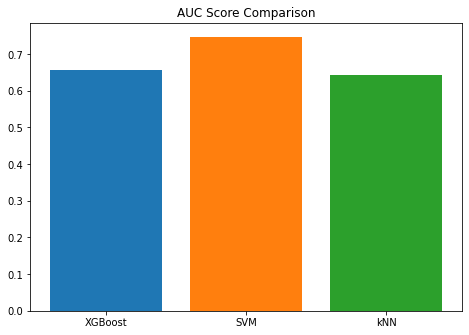

In [96]:
# Training the  models using the over sampled data 
train_test(models, X_train_2, y_train_2, X_test_1, y_test)

#dt 0.42/ 1
#svm 0.51/ 0.93
#knn 0.69/0.93

Another technique to deal with imbalance is the undersampling technique where instances of the majority class are randomly dropped to match the number of instances of minority class

In [97]:
# Under sampling 
mu = RandomUnderSampler(sampling_strategy='majority')
X_train_3,y_train_3 = mu.fit_resample(X_train,y_train)

In [98]:
y_train_3.value_counts()

0    207
1    207
Name: stroke, dtype: int64

In [99]:
X_train_3 = scaler.fit_transform(X_train_3)

In [100]:
#svm(X_train_3,y_train_3)

In [101]:
#knn(X_train_3, y_train_3)

In [102]:
#xgb(X_train_3, y_train_3)


In [103]:
models =[]
models.append(('XGBoost', XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=5, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=5,
              missing=np.nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1)))
models.append(('SVM', SVC(C=0.1, gamma=1, kernel='sigmoid', probability=True)))
models.append(('kNN', KNeighborsClassifier(n_neighbors=10, weights='distance')))

XGBoost: 0.758542 (0.018157)
SVM: 0.724655 (0.003501)
kNN: 0.753687 (0.013303)


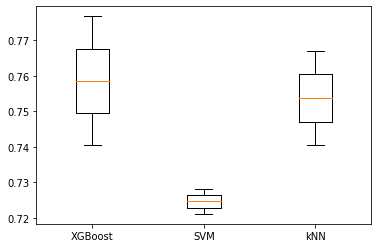

In [104]:
crossvalidation(models, X_train_3, y_train_3)

=========================XGBoost============================
              precision    recall  f1-score   support

           0       0.98      0.57      0.72       980
           1       0.07      0.76      0.13        42

    accuracy                           0.58      1022
   macro avg       0.53      0.67      0.43      1022
weighted avg       0.94      0.58      0.70      1022

=========================SVM============================
              precision    recall  f1-score   support

           0       0.99      0.54      0.70       980
           1       0.08      0.93      0.15        42

    accuracy                           0.56      1022
   macro avg       0.54      0.73      0.42      1022
weighted avg       0.96      0.56      0.68      1022

=========================kNN============================
              precision    recall  f1-score   support

           0       0.99      0.55      0.71       980
           1       0.07      0.81      0.13        42

    acc

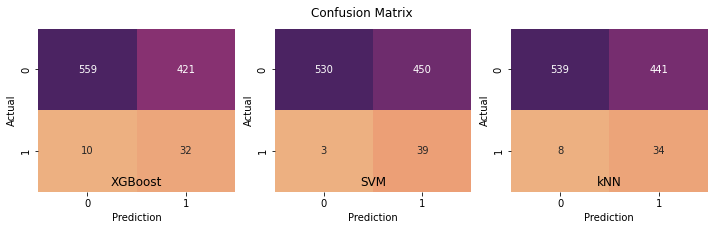

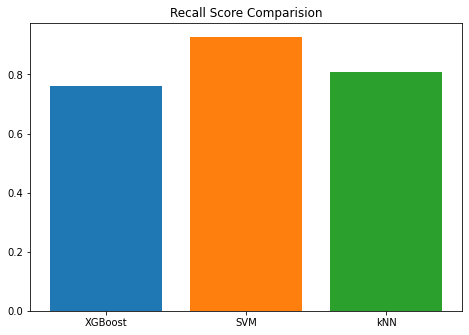

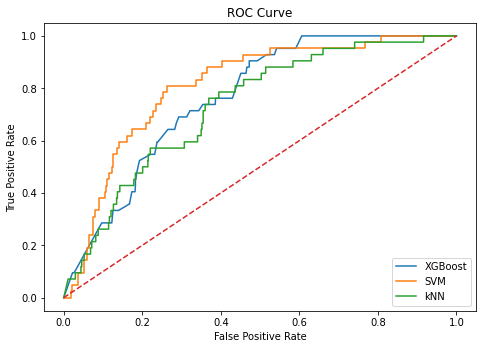

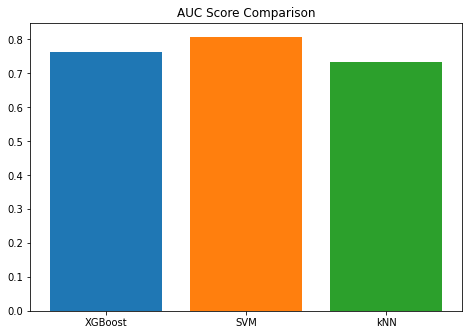

In [105]:
# Training the models using under sampled data 
train_test(models, X_train_3, y_train_3, X_test_1, y_test)

#DT 0.41/1
#SVM 0.53/0.9
#knn 0.61/0.83

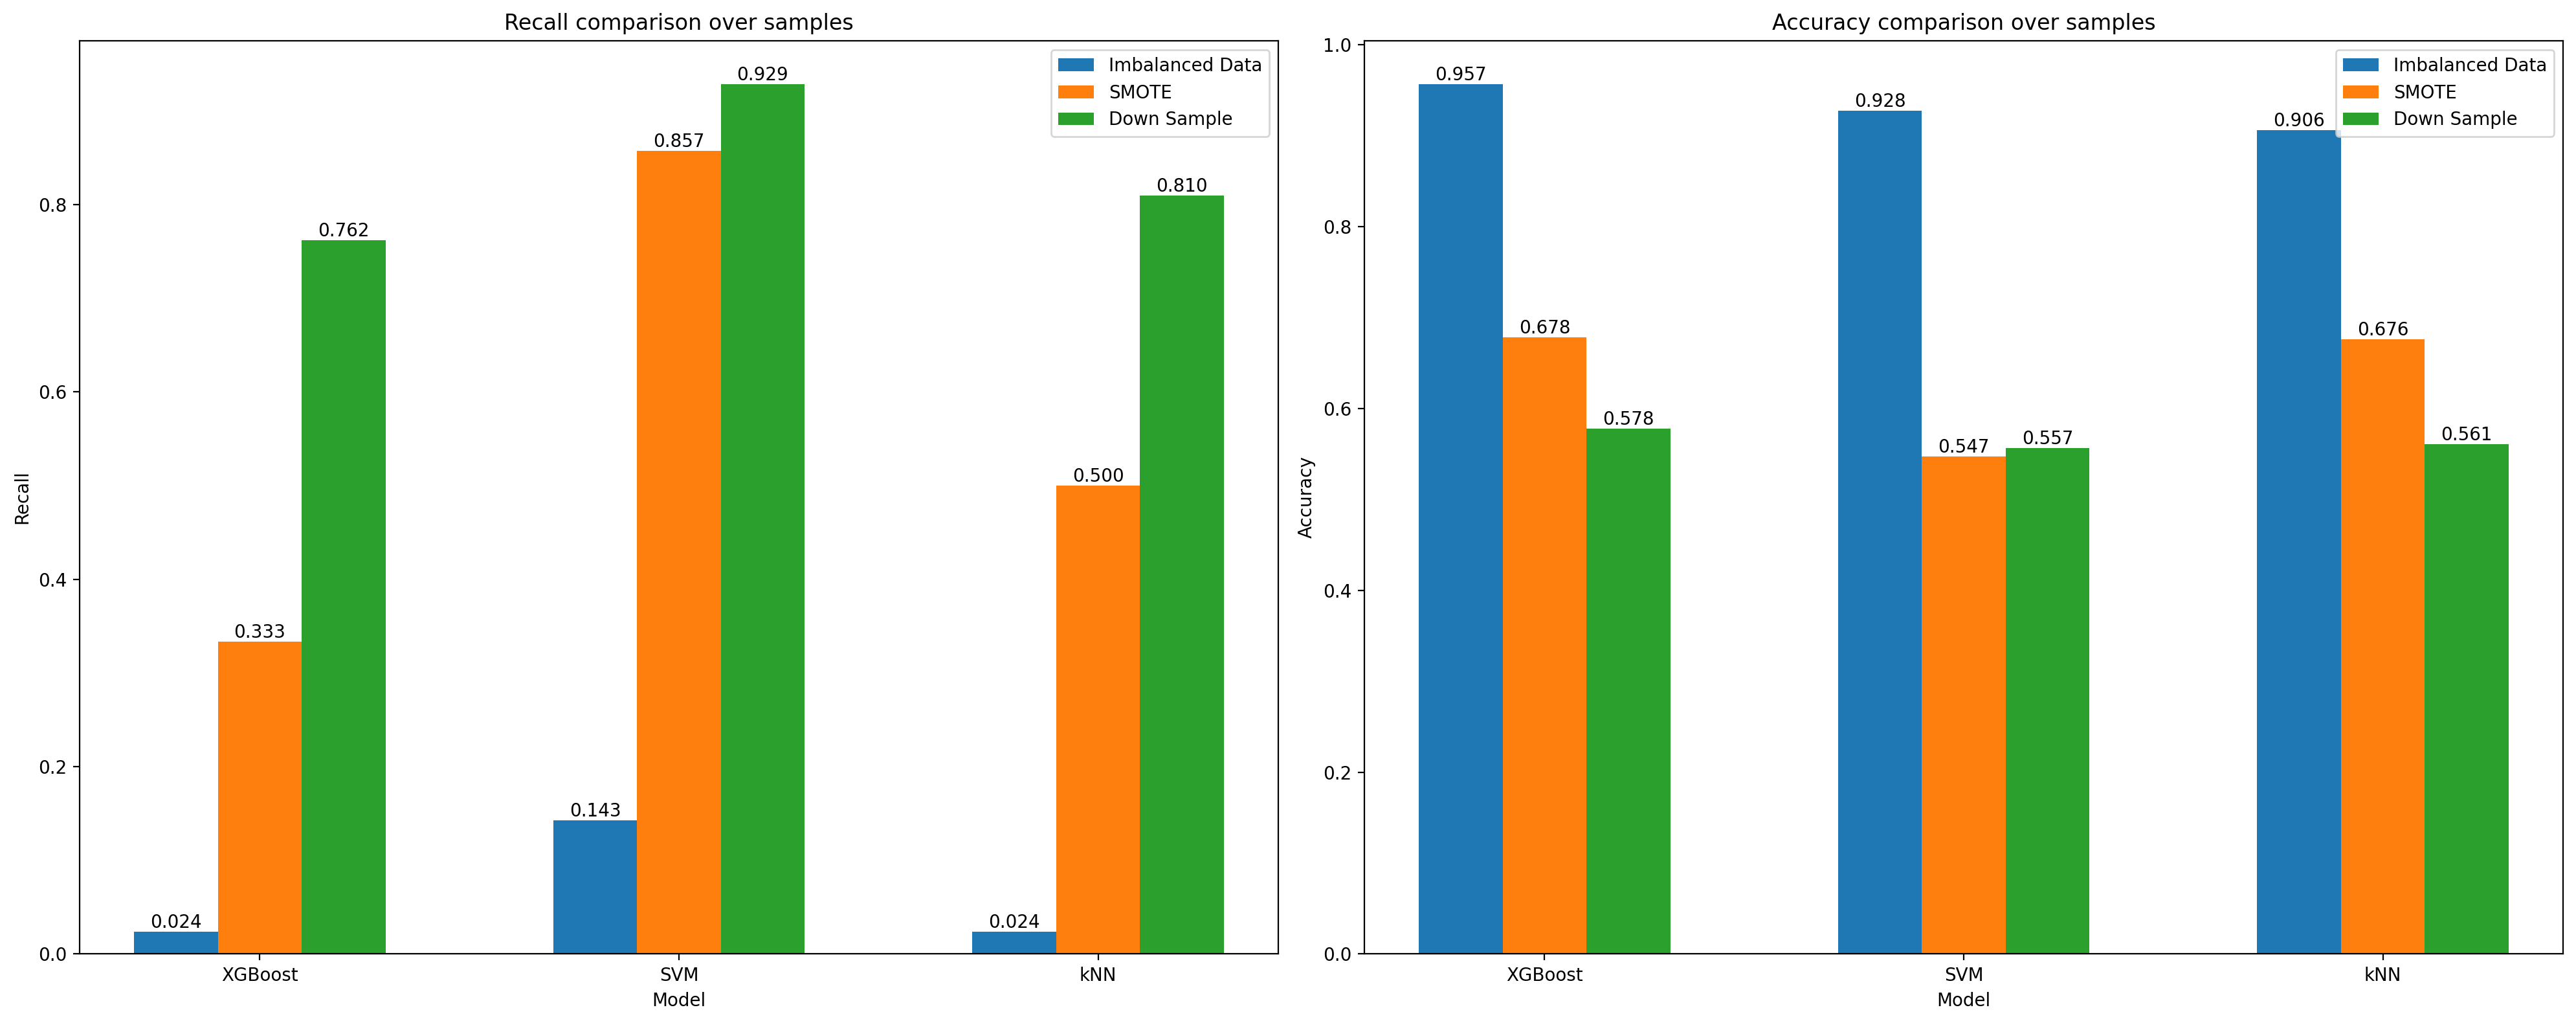

In [106]:
# Plotting the results graphs 
fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi = 200)
axnames =['XGBoost', 'SVM','kNN']
X_axis =np.arange(len(axnames))
imb_r = ax[0].bar(X_axis-0.2, results_recall[0], 0.2, label = 'Imbalanced Data')
sm_r = ax[0].bar(X_axis, results_recall[1],0.2, label = 'SMOTE')
ds_r = ax[0].bar(X_axis+0.2, results_recall[2],0.2, label = 'Down Sample')
ax[0].set_xlabel("Model")
ax[0].set_ylabel("Recall")
ax[0].set_title("Recall comparison over samples")
ax[0].bar_label(imb_r, fmt ='%.3f')
ax[0].bar_label(sm_r, fmt ='%.3f')
ax[0].bar_label(ds_r, fmt ='%.3f')
ax[0].set_xticks(X_axis,axnames)
ax[0].legend()


imb_a = ax[1].bar(X_axis-0.2, results_acc[0], 0.2, label = 'Imbalanced Data')
sm_a = ax[1].bar(X_axis, results_acc[1],0.2, label = 'SMOTE')
ds_a = ax[1].bar(X_axis+0.2, results_acc[2],0.2, label = 'Down Sample')
ax[1].set_xlabel("Model")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy comparison over samples")
ax[1].bar_label(imb_a, fmt ='%.3f')
ax[1].bar_label(sm_a, fmt ='%.3f')
ax[1].bar_label(ds_a, fmt ='%.3f')
ax[1].set_xticks(X_axis,axnames)
ax[1].legend()

plt.tight_layout()


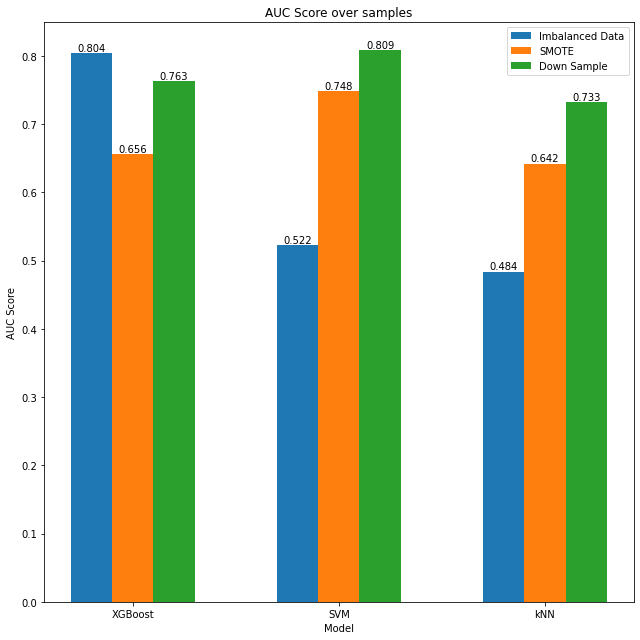

In [107]:
#fig, ax = plt.subplots(1, 1, figsize=(20, 8), dpi = 200)
axnames =['XGBoost', 'SVM','kNN']
X_axis =np.arange(len(axnames))
plt.figure(figsize=(9,9))
imb_a = plt.bar(X_axis-0.2, results_roc[0], 0.2, label = 'Imbalanced Data')
sm_a = plt.bar(X_axis, results_roc[1],0.2, label = 'SMOTE')
ds_a = plt.bar(X_axis+0.2, results_roc[2],0.2, label = 'Down Sample')
plt.xlabel("Model")
plt.ylabel("AUC Score")
plt.title("AUC Score over samples")
plt.bar_label(imb_a, fmt ='%.3f')
plt.bar_label(sm_a, fmt ='%.3f')
plt.bar_label(ds_a, fmt ='%.3f')
plt.xticks(X_axis,axnames)
plt.legend()

plt.tight_layout()
